In [1]:
# LIBRARY:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np

import statsmodels as sa

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline
%matplotlib nbagg

%cd /Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/bb_test_results/qvalues/GTEX-ALL_SAMPLES/

#%cd /Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/LogisticRegression_tests

/Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/bb_test_results/qvalues/GTEX-ALL_SAMPLES


In [2]:
# Import dataset:

df = pd.read_csv('GTEX-ALL_SAMPLES.v8.phASER.gw_phased.results.fdr_ALL.gene_info.zscores.txt.gz', sep='\t', compression='gzip')
#df = pd.read_csv('GTEX-FEMALES.v8.phASER_WASP.gw_phased.BetaBinom_vs_LogisticReg.ALL-TISSUES.gene_info.zscores.txt', sep='\t')

# add column for GENE_IDs without version #:
df[['GENE_ID','ens_version']] = df['GENE_ID'].str.split('.',expand=True)

df.head()

/Users/snkravitz/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CHR,GENE_ID,GENE_NAME,gene_start,gene_stop,SUBJECT_ID,tissue_num,data_pvalues,data_qvalues,data_lfdr,mean_read_counts,total_sample_count_females,total_sample_count_males,total_sample_count,count_fdr_0p1,daee_pctile_fdr_0p1,z_score,RME_effect,ens_version
0,1,ENSG00000228794,LINC01128,825137,859446,GTEX-SE5C,14.0,0.233974,0.655684,1.0,58.0,133.0,NaN,414,74.0,0.178744,0.315991,private_RME,8
1,1,ENSG00000223764,RP11-54O7.3,916869,919692,GTEX-SE5C,10.0,1.000000,1.000000,1.0,38.0,173.0,NaN,492,132.0,0.268293,0.915775,private_RME,2
2,1,ENSG00000188976,NOC2L,944581,959309,GTEX-SE5C,17.0,1.000000,1.000000,1.0,178.0,179.0,NaN,532,48.0,0.090226,-0.276891,private_RME,10
3,1,ENSG00000187961,KLHL17,960586,965715,GTEX-SE5C,15.0,0.473719,1.000000,1.0,24.0,160.0,NaN,473,34.0,0.071882,-0.399756,private_RME,13
4,1,ENSG00000187583,PLEKHN1,966496,975108,GTEX-SE5C,7.0,0.525752,1.000000,1.0,96.0,194.0,NaN,566,47.0,0.083039,-0.325026,private_RME,10


In [3]:
## Filter out X-Chr genes, Imprinted genes, and HLA genes:

# Remove X-Chr:
df = df[df['CHR'] != 'X']

# Remove HLA genes:
df = df[~df['GENE_NAME'].str.contains("HLA")]

# Remove Imprinted Genes:
imprinted_df = pd.read_csv("~/Documents/Gene_Lists/GTEx_Imprinting/GTEx_Imprinted_Table_S3andS4.uniq.txt", sep=' ', names=['GENE_ID', 'chrom', 'start'])
imprinted_genes = list(imprinted_df['GENE_ID'])
#imprinted_genes
df = df[~df['GENE_ID'].isin(imprinted_genes)]

In [4]:
## Get Median Tissue Number per Gene:

df_meds = df.groupby('GENE_ID')['tissue_num'].median().astype(int).to_frame().reset_index()

df_meds = df_meds.merge(df[['GENE_ID', 'z_score']], how='left', on='GENE_ID').drop_duplicates()


df_meds = df_meds.dropna()

df_meds.head()

,GENE_ID,tissue_num,z_score
0,ENSG00000000419,12,-0.619828
410,ENSG00000000457,18,-0.149095
1087,ENSG00000000460,17,1.860492
1815,ENSG00000000938,5,-0.729558
2080,ENSG00000000971,17,2.340941


In [5]:
df_meds.shape

(23481, 3)

<IPython.core.display.Javascript object>


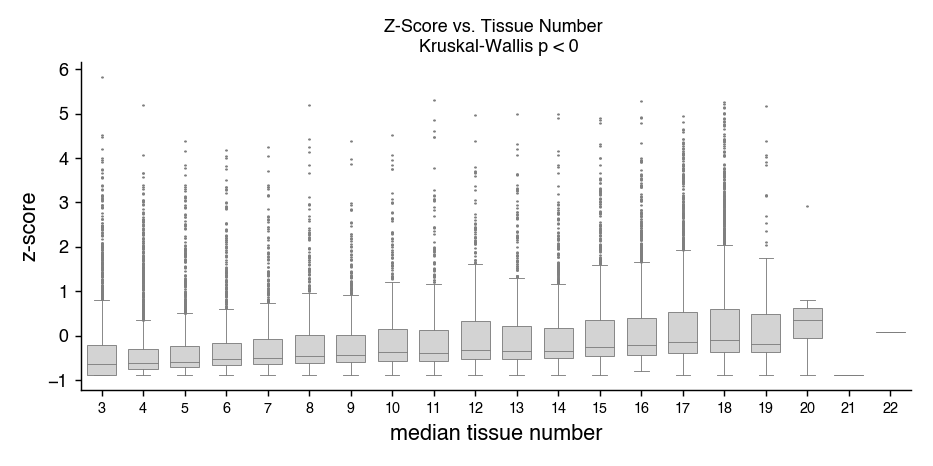

Text(0.5, 1.0, 'Z-Score vs. Tissue Number \n Kruskal-Wallis p < 0')

In [6]:
f, ax = plt.subplots(figsize=(4,2), tight_layout=True)
sns.despine()

tissue_nums = sorted(df_meds['tissue_num'].dropna().unique())

# Get ANOVA one-way p-value
tissue_dfs = []
for t in tissue_nums:
    tissue_dfs.append(df_meds['z_score'][df_meds['tissue_num'] == t].to_list())
    
#anova_p = stats.f_oneway(*[list(df_meds[df_meds['tissue_num']==t]['z_score'].astype(float)) for t in tissue_nums])
kruskal_p = stats.kruskal(*[list(df_meds[df_meds['tissue_num']==t]['z_score'].astype(float)) for t in tissue_nums])
#print(anova_p.pvalue)

ax = sns.boxplot(data = df_meds.dropna(), x = 'tissue_num', y = 'z_score', linewidth=0.5, fliersize=0.5, width=0.7, color="lightgray")
ax.set_xlabel('median tissue number', fontsize=12, fontweight='light')
ax.set_ylabel('z-score', fontsize=12, fontweight='light')
ax.set_xticklabels(tissue_nums, fontsize=8, fontweight='light')
ax.set_title('Z-Score vs. Tissue Number \n Kruskal-Wallis p < %.2g' % kruskal_p.pvalue, fontsize=10)


#plt.show()

#f.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.tissue_num.vs.z-score.pdf', transparent=True)
#f.savefig('GTEX-FEMALES.body-tissues.tissue_num.vs.LogisticReg_z-score_boxplots.pdf', transparent=True)


In [7]:
## Subset RME and Biallelic genes (and 'Unknown'):

df_meds['mosaic_category'] = np.where(df_meds['z_score'] >= 0.74, 'RME', 'Unknown')
df_meds['mosaic_category'] = np.where(df_meds['z_score'] < 0, 'Biallelic', df_meds['mosaic_category'])

df_meds.head()


,GENE_ID,tissue_num,z_score,mosaic_category
0,ENSG00000000419,12,-0.619828,Biallelic
410,ENSG00000000457,18,-0.149095,Biallelic
1087,ENSG00000000460,17,1.860492,RME
1815,ENSG00000000938,5,-0.729558,Biallelic
2080,ENSG00000000971,17,2.340941,RME


<IPython.core.display.Javascript object>


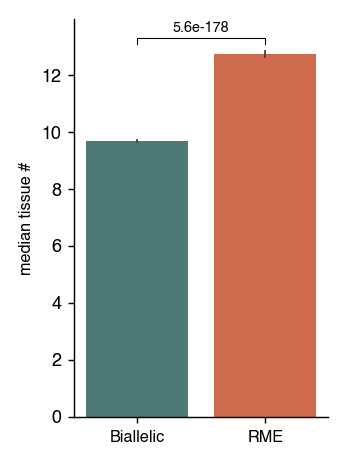

In [11]:
## Plot boxplot of Biallelic vs. RME genes for median TPMs:

f, ax = plt.subplots(figsize=(1.5, 2), tight_layout=True)
sns.despine()

f_oneway = stats.f_oneway(df_meds[df_meds['mosaic_category'] == 'Biallelic']['tissue_num'], df_meds[df_meds['mosaic_category'] == 'RME']['tissue_num'])


ax = sns.barplot(x='mosaic_category', y=df_meds['tissue_num'], data=df_meds[df_meds['mosaic_category'] != 'Unknown'], order=["Biallelic", "RME"], palette=["#46807D","#E35E39"], ci=68, errwidth=1)
ax.plot([0, 0, 1, 1], [13.1, 13.3, 13.3, 13.1], lw=0.6, c='k')
ax.text(0.5, 13.4, "%.2g" % f_oneway.pvalue, ha='center', va='bottom', color='k', fontsize=8)
ax.set_ylabel("median tissue #", fontsize=9, fontweight='light')
ax.set_xlabel("")
ax.set_xticklabels(['Biallelic', 'RME'], fontsize=9, fontweight='light')

plt.show()

#plt.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.tissue_num.vs.z-score_barplot.ci68.pdf', transparent=True)


In [7]:
df_meds.head()

,GENE_ID,tissue_num,z_score
0,ENSG00000000419,12,-0.619828
410,ENSG00000000457,18,-0.149095
1087,ENSG00000000460,17,1.860492
1815,ENSG00000000938,5,-0.729558
2080,ENSG00000000971,17,2.340941


<IPython.core.display.Javascript object>


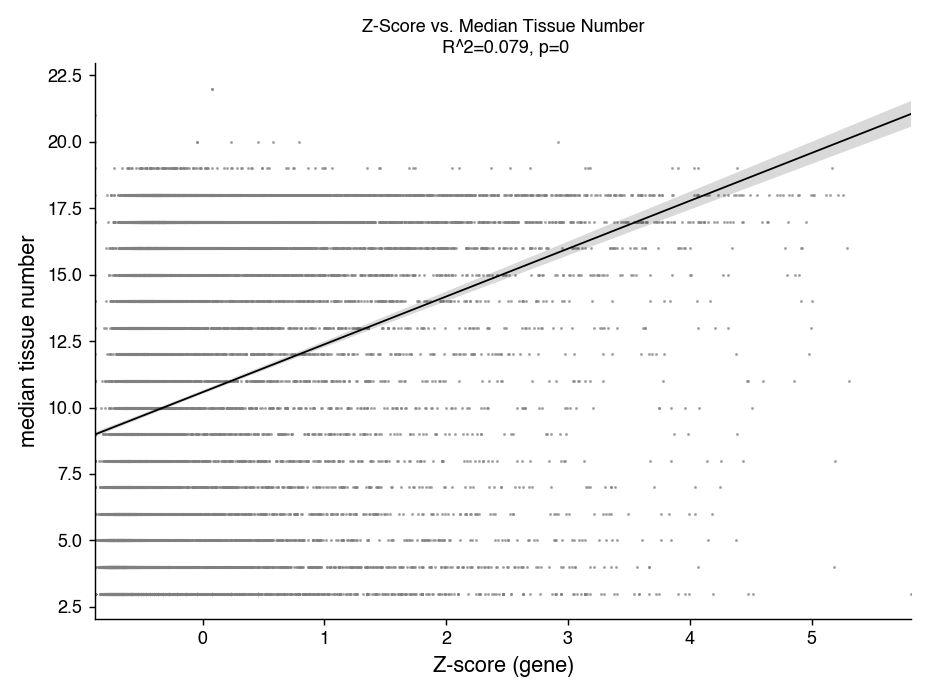

In [9]:
## Regression plot for z-score vs. median Tissue Number (to get R-squared value):


f, ax = plt.subplots(figsize=(4,3), tight_layout=True)
sns.despine()


slope, intercept, r_value, p_value, std_err = stats.linregress(df_meds['z_score'],df_meds['tissue_num'])
r_squared = r_value ** 2

ax = sns.regplot(data=df, x=df_meds['z_score'], y=df_meds['tissue_num'], fit_reg=True, truncate=True, ci=95, scatter_kws={"color":"grey", "s": 0.5, "alpha": 0.6, 'rasterized':True}, line_kws={"color":"black", "lw":1})
ax.set_xlabel('Z-score (gene)', fontsize=12, fontweight='light')
ax.set_ylabel('median tissue number', fontsize=12, fontweight='light')
ax.set_title('Z-Score vs. Median Tissue Number\n R^2={0:.2g}, p={1:.2g}'.format(r_squared,p_value), fontsize=10)


#f.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.tissue_num.vs.z-score_regplot.pdf', dpi=400, transparent=True)

